In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt 
import torch    
import tqdm

import mltools.utils.cuda_tools as cuda_tools
device=cuda_tools.get_freer_device()

memory_available [43481]
best GPU: 0


In [ ]:
yaml_path="/n/home12/cfpark00/ML/ToyCompDiff/data/images_1/2x2_final2/mirun_manyckpt5/sep_col=0.174_sep_size=0.4/seed=0/seed=0.yaml"
yaml_path="/n/home12/cfpark00/ML/ToyCompDiff/data/images_1/2x2_final2/mirun_manyckpt5/sep_col=0.174_sep_size=0.4/seed=0/"

In [452]:
config=utils.load_config(yaml_path)
color_means=np.array(config["data_params"]["color"]["means"])
size_means=np.array(config["data_params"]["size"]["means"])
color_means.shape,size_means.shape

((2, 3), (2,))

In [453]:
model=utils.get_model(config)
model.load_state_dict(torch.load(ckpt_path))
model=model.to(device)
model=model.eval()

In [454]:
model.model.w_cfg

In [416]:
#model.model.p_cfg=1.0
model.model.w_cfg=2.0

In [417]:
model.model.w_cfg

2.0

In [455]:
cs=[]
for i in range(4):
    l=[[0,0],[0,1],[1,0],[1,1]][i]
    c=torch.tensor([0.,0., 0., 0., *color_means[l[1]], size_means[l[0]], 0.,0.,0.])
    cs.append(c)
cs=torch.stack(cs).to(dtype=torch.float32,device=device)

rep=4
with torch.no_grad():
    ims=model.generate(cs.repeat(rep,1)).detach().cpu().numpy()
    ims=np.clip(ims.transpose(0,2,3,1),0,1).reshape(4,rep,32,32,3).transpose(1,0,2,3,4)
ims.shape

(4, 4, 32, 32, 3)

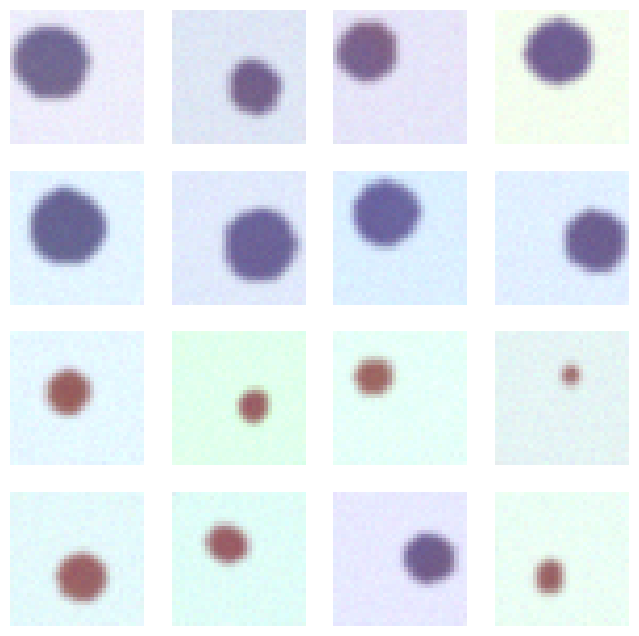

In [456]:
plt.figure(figsize=(8,8))
for row in range(4):
    for col in range(rep):
        plt.subplot(4,rep,row*rep+col+1)
        plt.imshow(ims[row,col].transpose(1,0,2),origin="lower")
        plt.axis("off")

In [449]:
cs=[]
for i in range(4):
    c=torch.tensor([0.,0., 0., 0., 0.4315, 0.5685, 0.4315, 0.65, 0.,0.,0.])
    cs.append(c)
cs=torch.stack(cs).to(dtype=torch.float32,device=device)

rep=4
with torch.no_grad():
    ims=model.generate(cs.repeat(rep,1)).detach().cpu().numpy()
    ims=np.clip(ims.transpose(0,2,3,1),0,1).reshape(4,rep,32,32,3).transpose(1,0,2,3,4)
ims.shape

(4, 4, 32, 32, 3)

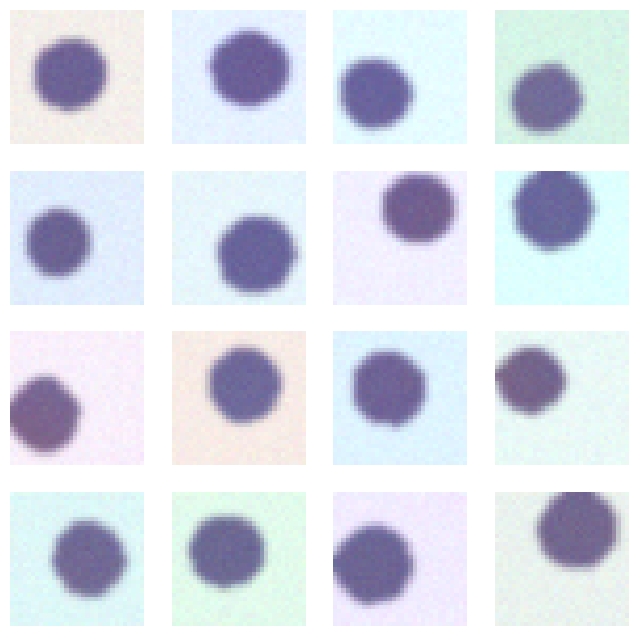

In [450]:
plt.figure(figsize=(8,8))
for row in range(4):
    for col in range(rep):
        plt.subplot(4,rep,row*rep+col+1)
        plt.imshow(ims[row,col].transpose(1,0,2),origin="lower")
        plt.axis("off")

In [405]:
ims.shape

(4, 4, 32, 32, 3)

In [406]:
ims[:,:,16,16].mean((0,1))

array([0.4807856 , 0.5512068 , 0.49177167], dtype=float32)

In [215]:
color_means

array([[0.5685, 0.4315, 0.4315],
       [0.4315, 0.4315, 0.5685]])

In [123]:
gens=torch.load("/n/home12/cfpark00/ML/ToyCompDiff/data/images_1/2x2_final2/col_sweep_cfg/sep_col=0.689_sep_size=0.4/seed=200/gens_w_cfg_7.5.pth")

In [128]:
gens["gens_tr"].shape

(60, 96, 3, 32, 32)

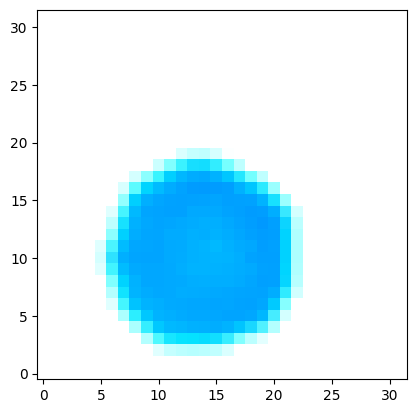

In [135]:
plt.imshow(np.clip(gens["gens_te"][-1,2].transpose(2,1,0),0,1),origin="lower")

In [11]:
model.model.training

True

In [480]:
x,y=torch.meshgrid(torch.linspace(0,1,12),torch.linspace(0,1,12),indexing="ij")
x_grid,y_grid=x.cpu().numpy(),y.cpu().numpy()
x,y=x.reshape(-1),y.reshape(-1)
color=x[:,None]*torch.tensor([-0.2,0.0,0.2])[None,:]+torch.tensor([0.6,0.4,0.4])[None,:]
size=y*(-0.4)+0.65
c=torch.cat([torch.zeros(1,4).repeat(len(x),1),color,size[:,None],torch.zeros(1,3).repeat(len(x),1)],dim=1)

In [481]:
from mltools.networks import networks
import models

classifier_ckpt_path="./data/images_1/2x2_final2/classifier_combined.pth"
net=networks.CUNet(shape=(3,32,32),out_channels=64,chs=[32,32,32],norm_groups=4)
classifier=models.Classifier(net=net,n_classes=[2,2])
classifier=classifier.to(device)
classifier.load_state_dict(torch.load(classifier_ckpt_path))
classifier=classifier.eval()

In [482]:
regressor_ckpt_path="./data/images_1/2x2_final2/regressor_combined.pth"

net=networks.CUNet(shape=(3,32,32),out_channels=64,chs=[32,32,32],norm_groups=4)
regressor=models.Classifier(net=net,out_dim=11)
regressor=regressor.to(device)
regressor.load_state_dict(torch.load(regressor_ckpt_path))
regressor=regressor.eval()

In [483]:
regress=True
rep=5
concept_space=[]
with torch.no_grad():
    for i in tqdm.trange(rep):
        ims=model.generate(c.to(device))
        if regress:
            class_probs=regressor.regress(ims)
            color=class_probs[:,4:7].detach().cpu().numpy()
            #project between (0.6,0.4,0.4) and (0.4,0.4,0.6)
            v0=np.array((0.6,0.4,0.4))
            v1=np.array((0.4,0.4,0.6))
            c_vec=v1-v0
            c_unit_vec=c_vec/np.linalg.norm(c_vec)
            c0proj=v0@c_unit_vec
            c1proj=v1@c_unit_vec
            x=color@c_unit_vec #project on color axis
            x=(x-c0proj)/(c1proj-c0proj)

            size=class_probs[:,7].detach().cpu().numpy()
            y=(size-0.65)/(-0.4)
            concept_space.append(np.stack([x,y],axis=-1))
        else:
            class_probs=classifier.classify(ims,return_probs=True)
            class_probs=np.stack([p.detach().cpu().numpy() for p in class_probs],axis=-1)
            concept_space.append(class_probs[:,1,:])
concept_space=np.stack(concept_space,axis=0)
concept_space.shape

100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


(5, 144, 2)

In [484]:
concept_space_grid=concept_space.mean(0).reshape(12,12,2)

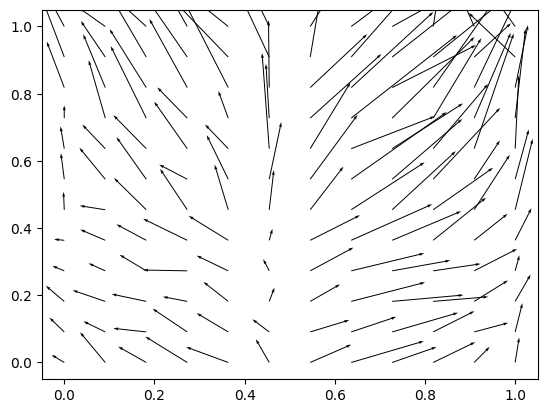

In [485]:
u=concept_space_grid[:,:,0]-x_grid
v=concept_space_grid[:,:,1]-y_grid
plt.quiver(x_grid,y_grid,u,v,angles="xy",scale_units='xy', scale=1,width=0.002)

In [331]:
class_probs=np.stack([p.detach().cpu().numpy() for p in class_probs],axis=-1)
rightprobs=class_probs[:,1,:]
class_probs.shape

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

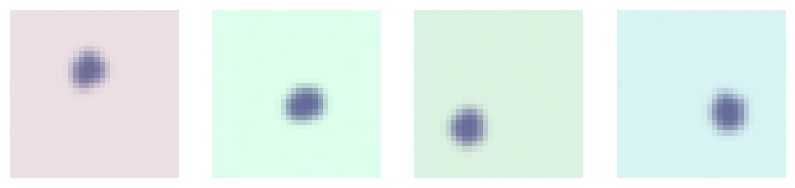

In [311]:
plt.figure(figsize=(10,10))
for i in range(rep):
    plt.subplot(1,rep,i+1)
    plt.imshow(ims[i].transpose(1,0,2),origin="lower")
    plt.axis("off")